**Data mining Project - University of Pisa, acedemic year 2023/24**
 
**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# K-Nearest Neighbors

KNN is a distance based algorithm useful for classification tasks. IT work by calculating the centroids of the samples belonging to the same class; the label is predicted by looking at wich is the most common class of the K points nearest to the one we want to classify.

In [1]:
import pandas as pd
import json
import pickle
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score
from time import time
from classification_utils import *
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
RESULTS_DIR = '../data/classification_results'
SEED=42
clf_name = 'KNearestNeighborsClassifier'

We load the dataset and the features used for classification.

In [2]:
# load the data
incidents_train_df = pd.read_csv('../data/clf_indicators_train.csv', index_col=0)
incidents_test_df = pd.read_csv('../data/clf_indicators_test.csv', index_col=0)
true_labels_train_df = pd.read_csv('../data/clf_y_train.csv', index_col=0)
true_labels_train = true_labels_train_df.values.ravel()
true_labels_test_df = pd.read_csv('../data/clf_y_test.csv', index_col=0)
true_labels_test = true_labels_test_df.values.ravel()

# load the names of the features to use for the classification task
features_for_clf = json.loads(open('../data/clf_indicators_names_distance_based.json').read())

# project on the features to use
indicators_train_df = incidents_train_df[features_for_clf]
indicators_test_df = incidents_test_df[features_for_clf]

We display the features names we will use.

In [3]:
print(features_for_clf)
print(f'Number of features: {len(features_for_clf)}')

['location_imp', 'x', 'y', 'age_range', 'avg_age', 'n_child_prop', 'n_teen_prop', 'n_males_prop', 'n_participants', 'day_x', 'day_y', 'day_of_week_x', 'day_of_week_y', 'month_x', 'month_y', 'year', 'days_from_first_incident', 'poverty_perc', 'democrat', 'gun_law_rank', 'aggression', 'accidental', 'defensive', 'suicide', 'road', 'house', 'school', 'business', 'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction']
Number of features: 34


We make a 5-fold cross validation in which we check which is the best value for each hyperparameter (*n_neighbors*, *weights*, *algorithm*, *metric*, *p*). The parameters we select in this section are chosen on the basis of previous test, looking at the ones which performed better. <br>
The values for training are scaled to be between 0 and 1 so that bigger values in module, and so bigger distances, don't affect the classification.

In [14]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
scaler = MinMaxScaler()
knn = KNeighborsClassifier()
pipe = Pipeline(steps=[('scaler', scaler), ('knn', knn)])

param_grid = [
    {
        'knn__n_neighbors': [1, 3, 5, 9, 15], # odd values to avoid ties
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm': ['brute'],
        'knn__metric': ['minkowski'],
        'knn__p': [1, 2]
    }
]

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=-1,
    scoring=make_scorer(f1_score),
    verbose=10,
    cv=cv,
    refit=False
)
gs.fit(indicators_train_df, true_labels_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'knn__algorithm': ['brute'],
                          'knn__metric': ['minkowski'],
                          'knn__n_neighbors': [1, 3, 5, 9, 15],
                          'knn__p': [1, 2],
                          'knn__weights': ['uniform', 'distance']}],
             refit=False, scoring=make_scorer(f1_score), verbose=10)

We display some metrics derived from cross validation fitting.

In [15]:
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df.columns = [col.replace('knn__', '') for col in cv_results_df.columns]
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_metric,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.178792,0.032368,85.122059,0.987499,brute,minkowski,1,1,uniform,"{'knn__algorithm': 'brute', 'knn__metric': 'minkowski', 'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}",0.462315,0.452024,0.449355,0.450455,0.452112,0.453252,0.004647,9
1,0.129218,0.010784,85.082876,4.011861,brute,minkowski,1,1,distance,"{'knn__algorithm': 'brute', 'knn__metric': 'minkowski', 'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'distance'}",0.462315,0.452024,0.449355,0.450455,0.452112,0.453252,0.004647,9
2,0.121637,0.002946,17.778714,0.199599,brute,minkowski,1,2,uniform,"{'knn__algorithm': 'brute', 'knn__metric': 'minkowski', 'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'uniform'}",0.461913,0.456915,0.459430,0.464804,0.466787,0.461970,0.003557,1
3,0.121359,0.005814,15.956096,0.170684,brute,minkowski,1,2,distance,"{'knn__algorithm': 'brute', 'knn__metric': 'minkowski', 'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'distance'}",0.461913,0.456915,0.459430,0.464804,0.466787,0.461970,0.003557,1
4,0.119436,0.004879,83.640536,0.115824,brute,minkowski,3,1,uniform,"{'knn__algorithm': 'brute', 'knn__metric': 'minkowski', 'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}",0.456558,0.443040,0.456621,0.441006,0.457822,0.451010,0.007379,12


We plot the heatmap of the scores, on the test set, archieved by each classifier with different paramenters. It gives an idea of the importance of each parameter and the variation of the performance in changing their values.

<Axes: xlabel='param_p-param_weights', ylabel='param_n_neighbors'>

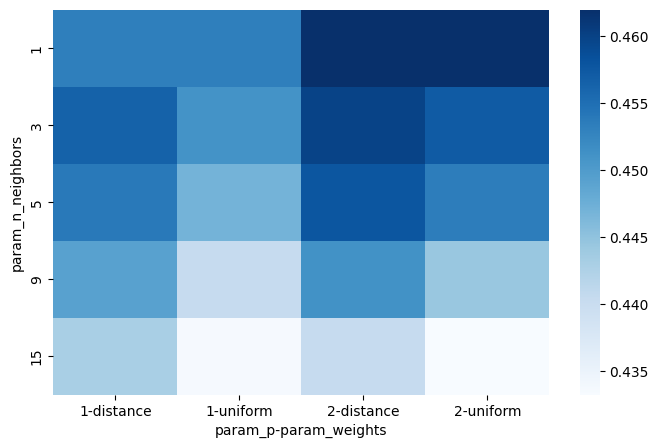

In [16]:
fig, axs = plt.subplots(1, figsize=(8, 5))
pvt_manhattan = pd.pivot_table(
    cv_results_df,
    values='mean_test_score',
    columns=['param_p', 'param_weights'],
    index=['param_n_neighbors']
)
sns.heatmap(pvt_manhattan, cmap='Blues')

From the heatmaps we can see that is foundamental to use Manhattan distance (p=1) and weighted distances in order to archieve better performance. As we expected, there is just a slight variation in the score changing the number of neighbors; in fact those are some of the best parameters chosen in a wider range. <br>
In these settings, it turns out that the most influent hyperparameters are *weights*, *metric* and *p*.

We display the mean and standard deviation of the score of the models fitted in the cross validation. These values are calculated on the test set.

In [18]:
params = [col for col in cv_results_df.columns if 'param_' in col and 'random' not in col]
cv_results_df.sort_values(
    by='mean_test_score',
    ascending=False)[params+['std_test_score', 'mean_test_score']].head(20).style.background_gradient(subset=['std_test_score', 'mean_test_score'], cmap='Blues')

,param_algorithm,param_metric,param_n_neighbors,param_p,param_weights,std_test_score,mean_test_score
2,brute,minkowski,1,2,uniform,0.003557,0.461970
3,brute,minkowski,1,2,distance,0.003557,0.461970
7,brute,minkowski,3,2,distance,0.003361,0.459899
11,brute,minkowski,5,2,distance,0.003195,0.457714
6,brute,minkowski,3,2,uniform,0.004077,0.457153
5,brute,minkowski,3,1,distance,0.005890,0.456449
9,brute,minkowski,5,1,distance,0.005645,0.453935
10,brute,minkowski,5,2,uniform,0.004960,0.453447
1,brute,minkowski,1,1,distance,0.004647,0.453252
0,brute,minkowski,1,1,uniform,0.004647,0.453252


We make a random oversampling on the positive class such that fatal incidents become 40% of the total number of records. Doing oversampling we can help classifier make better predictions on test set, but we don't reach a 50-50 ratio since it may be unrealistic.

In [19]:
# minority oversampling
indicators_oversampled_train_df = pd.read_csv('../data/clf_indicators_train_over.csv', index_col=0)
indicators_oversampled_train_df = indicators_oversampled_train_df[features_for_clf]
true_oversampled_labels_train = pd.read_csv('../data/clf_y_train_over.csv', index_col=0).values.ravel()

# SMOTE oversampling
indicators_smote_train_df = pd.read_csv('../data/clf_indicators_train_smote.csv', index_col=0)
indicators_smote_train_df = indicators_smote_train_df[features_for_clf]
true_labels_smote_train = pd.read_csv('../data/clf_y_train_smote.csv', index_col=0).values.ravel()

C:\Users\lucam\AppData\Local\Temp\ipykernel_11924\438407527.py:5: DtypeWarning: Columns (11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  indicators_oversampled_train_df = pd.read_csv('../data/clf_indicators_train_over.csv', index_col=0)


We fit the best model we got from cross validation, then we make and save the predictions on test set. Finally we save the models so that we can reuse it without performing the training.

In [23]:
best_index = gs.best_index_
best_model_params = cv_results_df.loc[best_index]['params']
best_model_params = {k.replace('knn__', ''): v for k, v in best_model_params.items()}
best_model = KNeighborsClassifier(**best_model_params)
best_model_oversampled = KNeighborsClassifier(**best_model_params)
best_model_smote = KNeighborsClassifier(**best_model_params)

# scale all the data
minmax_scaler = MinMaxScaler()
indicators_train_scaled = minmax_scaler.fit_transform(indicators_train_df)
indicators_oversampled_train_scaled = minmax_scaler.fit_transform(indicators_oversampled_train_df)
indicators_smote_train_scaled = minmax_scaler.fit_transform(indicators_smote_train_df)
indicators_test_scaled = minmax_scaler.fit_transform(indicators_test_df)


# fit the model on all the training data
fit_start = time()
best_model.fit(indicators_train_scaled, true_labels_train)
fit_time = time()-fit_start

# fit the model on all the training data (oversampled)
fit_start = time()
best_model_oversampled.fit(indicators_oversampled_train_scaled, true_oversampled_labels_train)
fit_time_oversampled = time()-fit_start

# fit the model on all the training data (smote)
fit_start = time()
best_model_smote.fit(indicators_smote_train_scaled, true_labels_smote_train)
fit_time_smote = time()-fit_start


# get the predictions on the training data
train_score_start = time()
pred_labels_train = best_model.predict(indicators_train_scaled)
train_score_time = time()-train_score_start
pred_probas_train = best_model.predict_proba(indicators_train_scaled)

# get the predictions on the training data (oversampled)
train_score_start = time()
pred_labels_oversampled_train = best_model_oversampled.predict(indicators_oversampled_train_scaled)
train_score_time_oversampled = time()-train_score_start
pred_probas_oversampled_train = best_model_oversampled.predict_proba(indicators_oversampled_train_scaled)

# get the predictions on the training data (smote)
train_score_start = time()
pred_labels_smote_train = best_model_smote.predict(indicators_smote_train_scaled)
train_score_time_smote = time()-train_score_start
pred_probas_smote_train = best_model_smote.predict_proba(indicators_smote_train_scaled)


# get the predictions on the test data
test_score_start = time()
pred_labels_test = best_model.predict(indicators_test_scaled)
test_score_time = time()-test_score_start
pred_probas_test = best_model.predict_proba(indicators_test_scaled)

# get the predictions on the test data (oversampled)
test_score_start = time()
pred_labels_oversampled_test = best_model_oversampled.predict(indicators_test_scaled)
test_score_time_oversampled = time()-test_score_start
pred_probas_oversampled_test = best_model_oversampled.predict_proba(indicators_test_scaled)

# get the predictions on the test data (smote)
test_score_start = time()
pred_labels_smote_test = best_model_smote.predict(indicators_test_scaled)
test_score_time_smote = time()-test_score_start
pred_probas_smote_test = best_model_smote.predict_proba(indicators_test_scaled)


# save the predictions
pd.DataFrame(
    {'labels': pred_labels_test, 'probs': pred_probas_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_preds.csv')

# save the predictions (oversampled)
pd.DataFrame(
    {'labels': pred_labels_oversampled_test, 'probs': pred_probas_oversampled_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_oversampled_preds.csv')

# save the predictions (smote)
pd.DataFrame(
    {'labels': pred_labels_smote_test, 'probs': pred_probas_smote_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_smote_preds.csv')


# save the model
file = open(f'{RESULTS_DIR}/{clf_name}.pkl', 'wb')
pickle.dump(obj=best_model, file=file)
file.close()

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_oversampled.pkl', 'wb')
pickle.dump(obj=best_model_oversampled, file=file)
file.close()

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_smote.pkl', 'wb')
pickle.dump(obj=best_model_smote, file=file)
file.close()


# save the cv results
best_model_cv_results = pd.DataFrame(cv_results_df.iloc[best_index]).T
best_model_cv_results.index = [clf_name]
best_model_cv_results.to_csv(f'{RESULTS_DIR}/{clf_name}_train_cv_scores.csv')

We display some classification scores in order to have some metrics useful to make comparisions with other models. These scores are refearing to predictions on training and test set including oversampled and smote.

In [24]:
compute_clf_scores(
    y_true=true_labels_train,
    y_pred=pred_labels_train,
    train_time=fit_time,
    score_time=train_score_time,
    params=best_model_params,
    prob_pred=pred_probas_train,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
KNearestNeighborsClassifier,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.029,35.125356,"{'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}"


In [25]:
compute_clf_scores(
    y_true=true_oversampled_labels_train,
    y_pred=pred_labels_oversampled_train,
    train_time=fit_time_oversampled,
    score_time=train_score_time_oversampled,
    params=best_model_params,
    prob_pred=None,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_oversampled_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
KNearestNeighborsClassifier,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,None,0.032001,65.032005,"{'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}"


In [26]:
compute_clf_scores(
    y_true=true_labels_smote_train,
    y_pred=pred_labels_smote_train,
    train_time=fit_time_smote,
    score_time=train_score_time_smote,
    params=best_model_params,
    prob_pred=None,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_smote_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
KNearestNeighborsClassifier,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,None,0.033998,66.222023,"{'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}"


In [27]:
compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    train_time=fit_time,
    score_time=test_score_time,
    params=best_model_params,
    prob_pred=pred_probas_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_test_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
KNearestNeighborsClassifier,0.747327,0.759142,0.753188,0.470692,0.454887,0.462655,0.609009,0.607015,0.607921,0.658769,0.661743,0.660182,0.661743,0.607015,0.029,25.944002,"{'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}"


In [7]:
compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_oversampled_test,
    train_time=fit_time_oversampled,
    score_time=train_score_time_oversampled,
    params=best_model_params,
    prob_pred=pred_probas_oversampled_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_oversampled_test_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
KNearestNeighborsClassifier,0.747327,0.759142,0.753188,0.470692,0.454887,0.462655,0.609009,0.607015,0.607921,0.658769,0.661743,0.660182,0.661743,0.607015,0.032001,65.032005,"{'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}"


In [6]:
compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    train_time=fit_time_smote,
    score_time=train_score_time_smote,
    params=best_model_params,
    prob_pred=pred_probas_smote_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_smote_test_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
KNearestNeighborsClassifier,0.754252,0.741193,0.747665,0.469839,0.487116,0.478321,0.612045,0.614154,0.612993,0.663205,0.659857,0.661442,0.659857,0.614154,0.033998,66.222023,"{'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}"


Since the model with better performance (better f1-score macro) is the one trained on smote oversampled data, we will use it for further analisys.

We plot the diffusion matrix in orther to know what is the balancing between false positves, false negatives, true positives and true negatives.

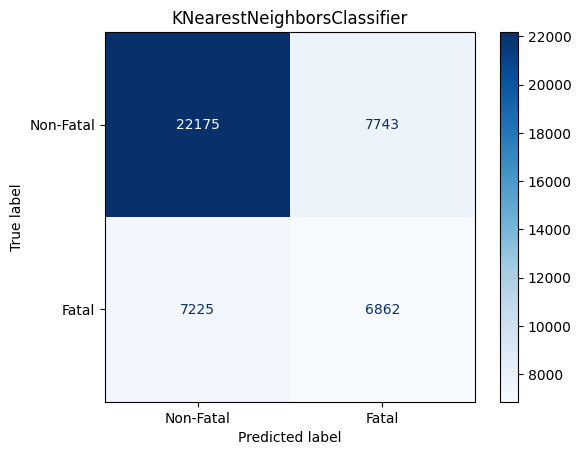

In [30]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    title=clf_name
)

We can see we have similar situation in terms of precision and recall, both for fatal and non fatal incidents.

We plot the classification labels in the bidimensional feature spaces obtained pairing 4 features: **aggression**, **drug_alcohol**, **gun_law_rank** and **n_males**.

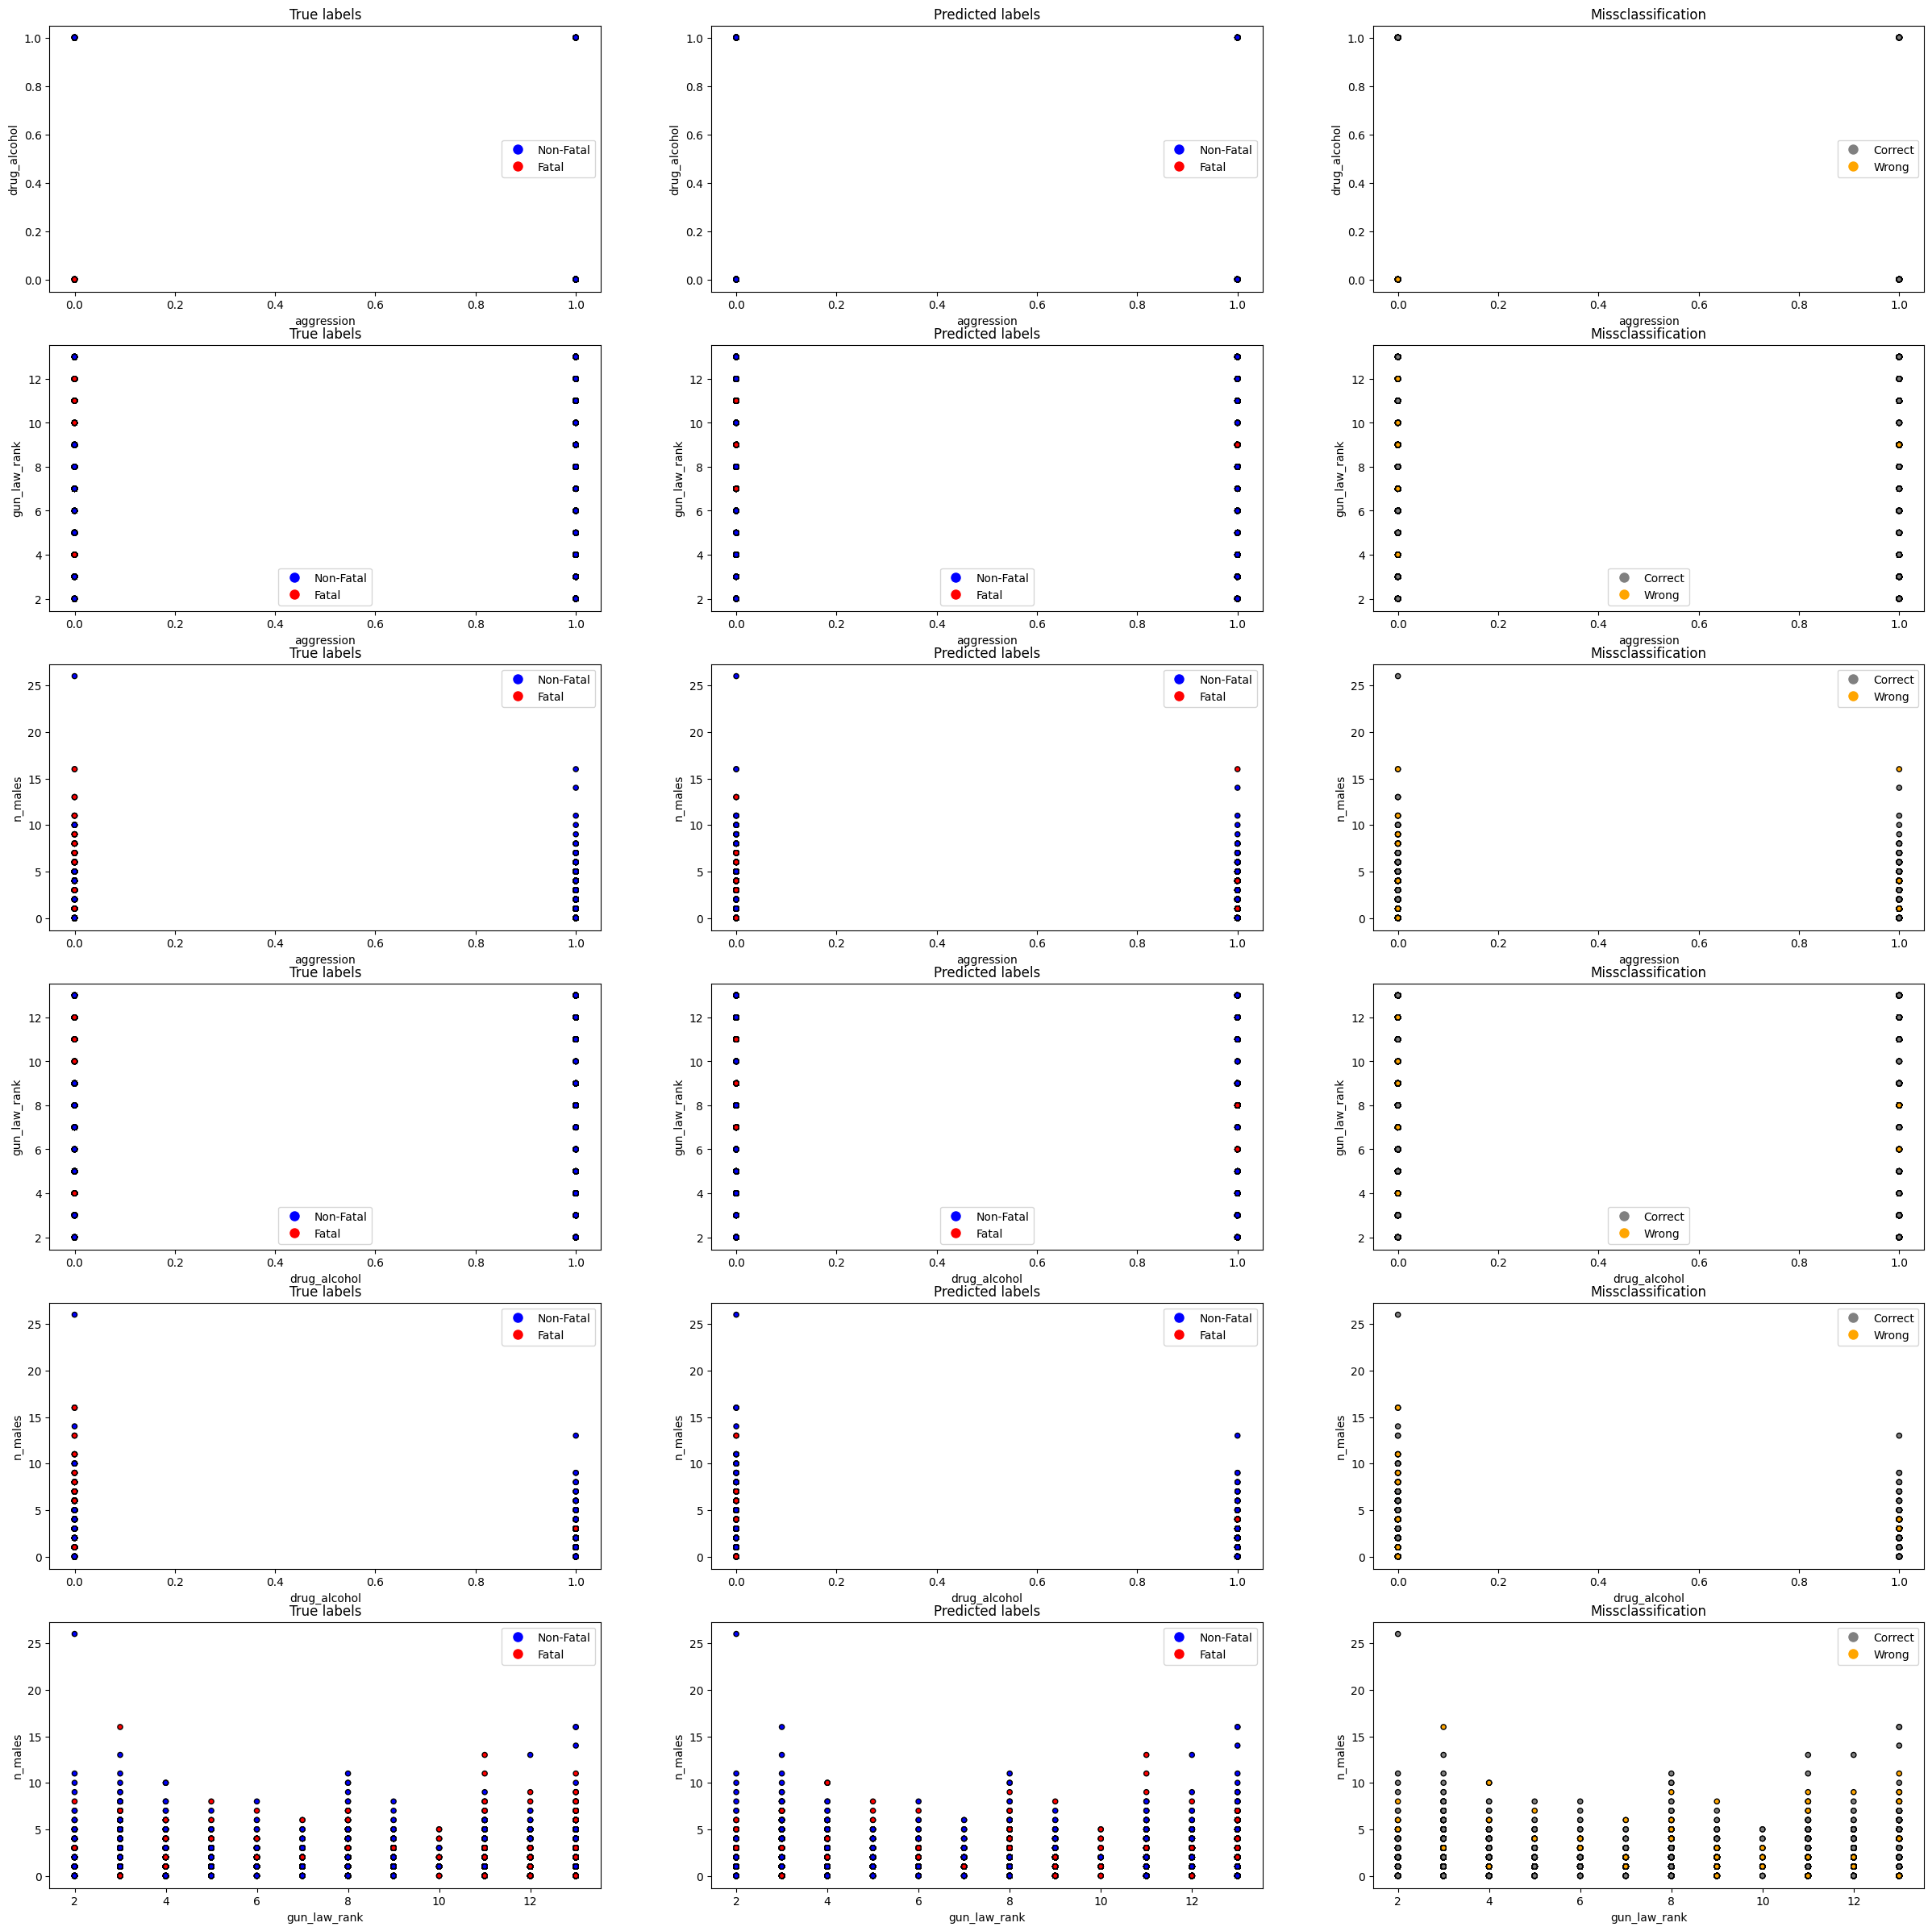

In [31]:
plot_predictions_in_features_space(
    df=incidents_test_df,
    features=['aggression', 'drug_alcohol', 'gun_law_rank', 'n_males'],
    true_labels=true_labels_test,
    pred_labels=pred_labels_smote_test,
    figsize=(30, 30)
)

Given the plot, although we can't deduce anything on the separation of clusters, we can notice that when **aggression** and **drug_alcohol** are set to 1, the incidents are generally not fatal, but the model makes few mistakes with them.

We plot the ROC curve of the model basing on its prediction on test set.

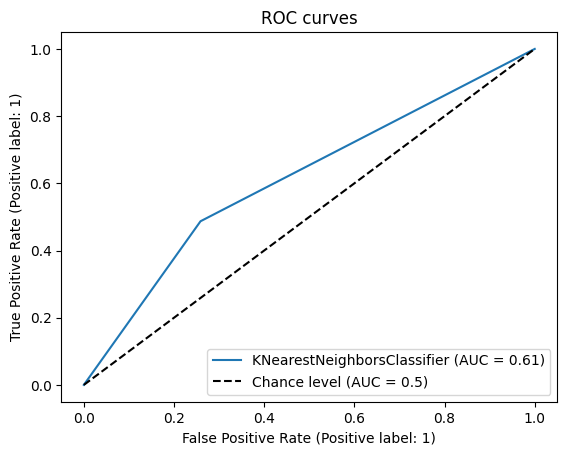

In [33]:
plot_roc(y_true=true_labels_test, y_probs=[pred_probas_smote_test[:,1]], names=[clf_name])

We permorm PCA and we plot the decision boundary of the first two components.

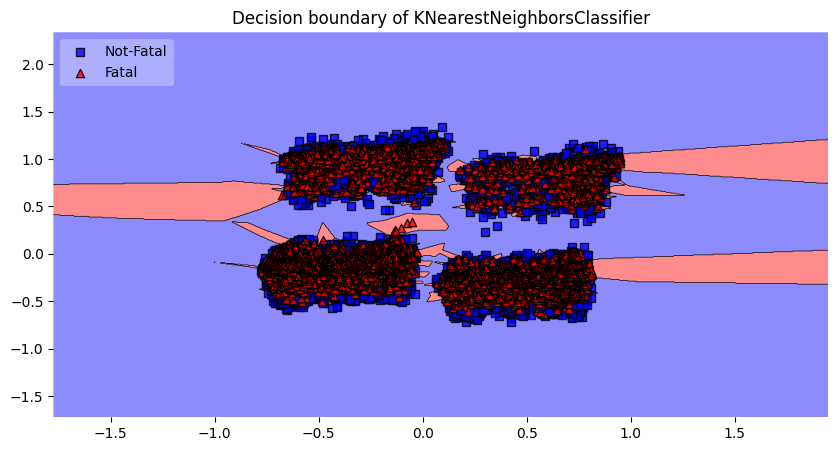

In [35]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_PCA_decision_boundary(
  train_set=indicators_smote_train_scaled,
  features=indicators_train_df.columns,
  train_label=true_labels_smote_train,
  classifier=best_model_smote,
  classifier_name=clf_name,
  axs=axs
)

In the feature space of the first two components we have an indented boundary which has only small zones for fatal incidents.

We plot the learning curve of the model. Each time we perform training in a subsample of the dataset and see how the results vary.

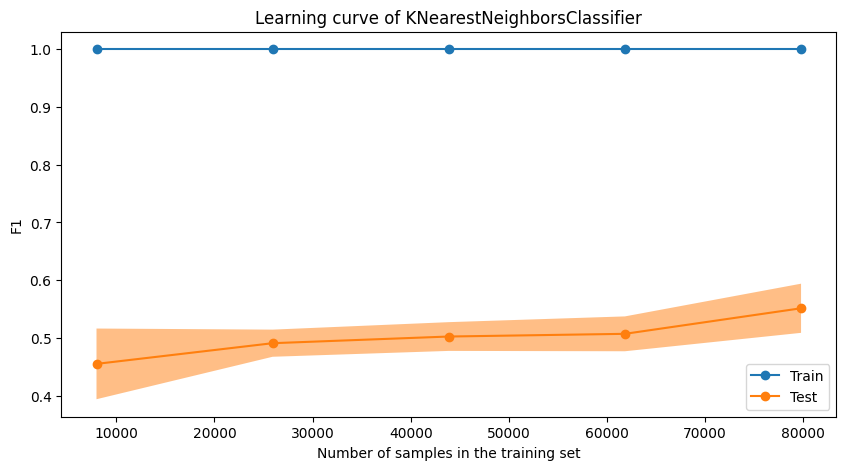

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_learning_curve(
    classifier=best_model_smote,
    classifier_name=clf_name,
    train_set=indicators_smote_train_scaled,
    labels=true_labels_smote_train,
    ax=axs,
    train_sizes=np.linspace(0.1, 1.0, 5),
    metric='f1'
)

While training error is always 1, we have F1-score which has small improvements with the increasing of training samples. Standard deviation of the test score is generally small, but it grow up with very few or very much training samples.

We plot the curve of the F1 score for different values of k.

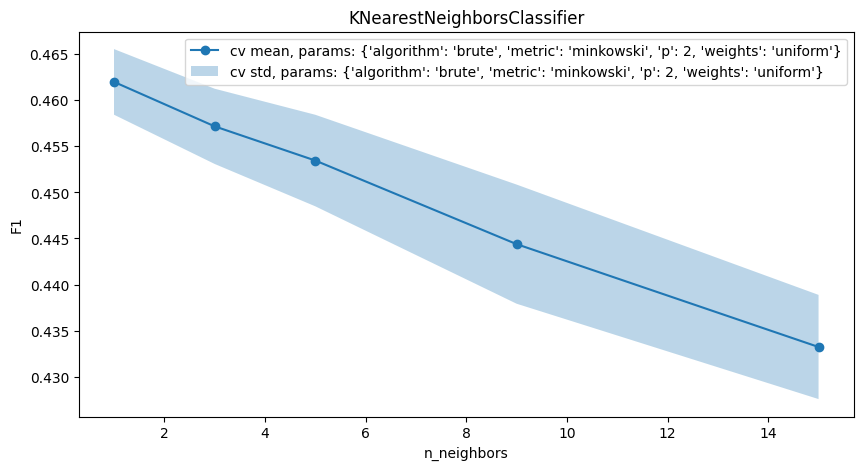

In [37]:
param_of_interest = 'n_neighbors'
fixed_params = best_model_params.copy()
fixed_params.pop(param_of_interest)
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_scores_varying_params(
    cv_results_df,
    param_of_interest,
    fixed_params,
    'F1',
    axs,
    title=clf_name
)

We can see how incrementing the number of neighbors the F1-score decrease almost linearly.

We display with different types of plot the distribution of the values of the miscassified incidents of **n_killed**, **suicide**, **aggression**, **road** and **location_imp**.

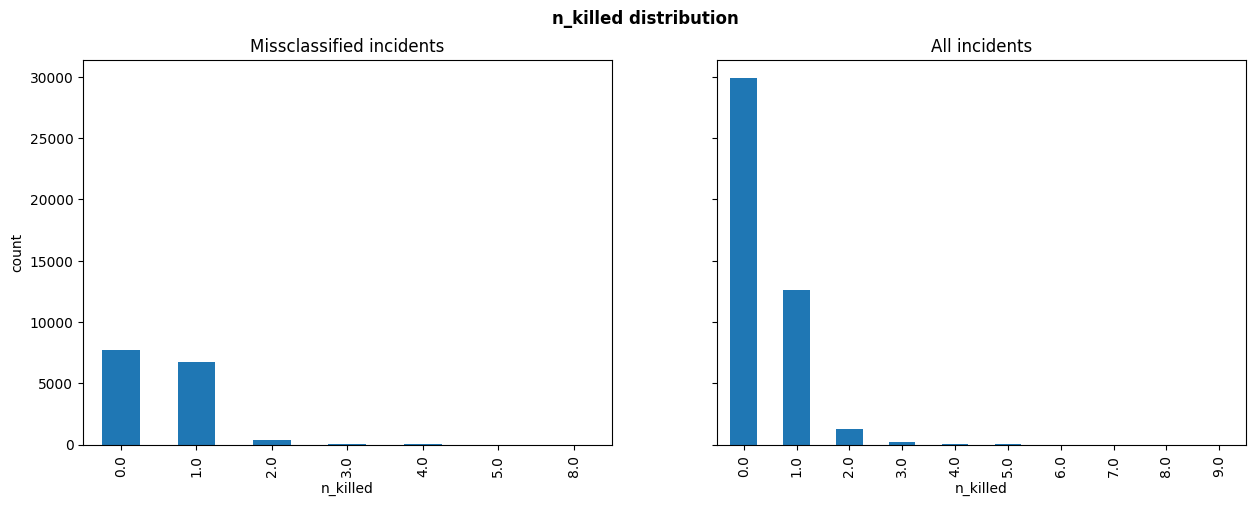

In [38]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_smote_test,
    incidents_test_df,
    'n_killed',
    'bar',
    title='n_killed distribution'
)

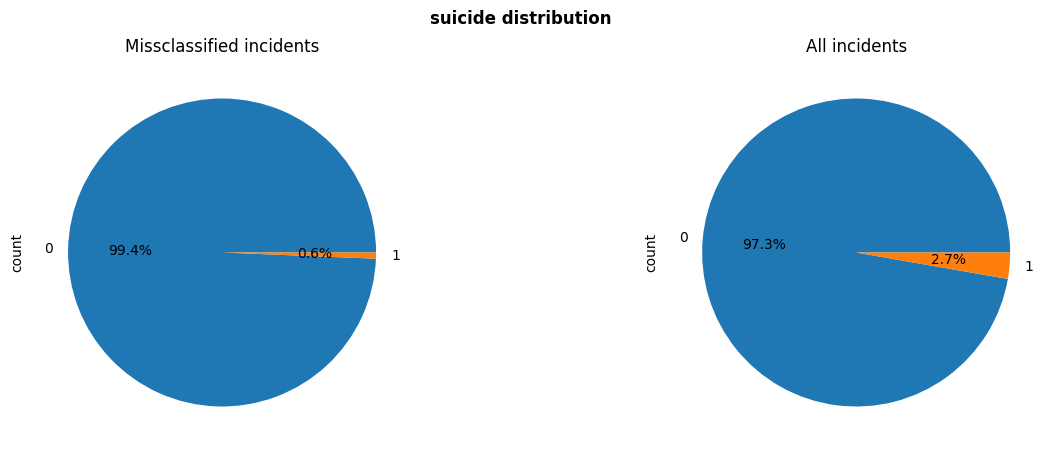

In [39]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_smote_test,
    incidents_test_df,
    'suicide',
    'pie',
    title='suicide distribution'
)

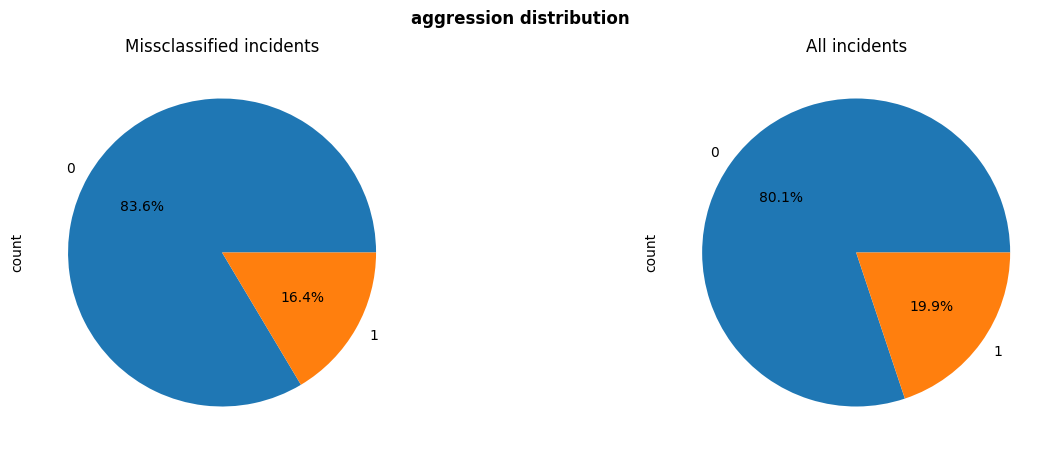

In [40]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_smote_test,
    incidents_test_df,
    'aggression',
    'pie',
    title='aggression distribution'
)

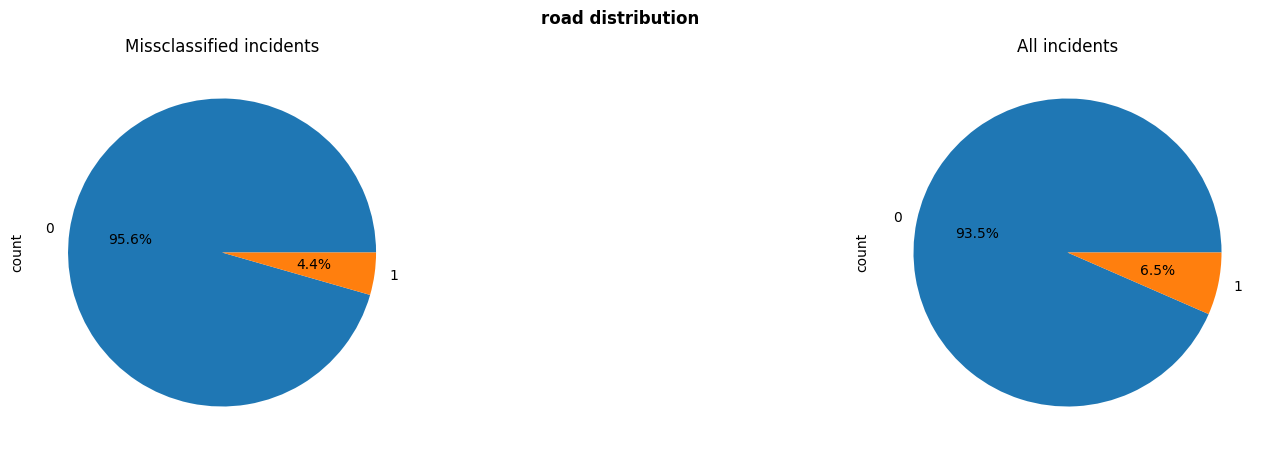

In [41]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_smote_test,
    incidents_test_df,
    'road',
    'pie',
    pie_perc_threshold=2,
    figsize=(20, 5),
    title='road distribution'
)

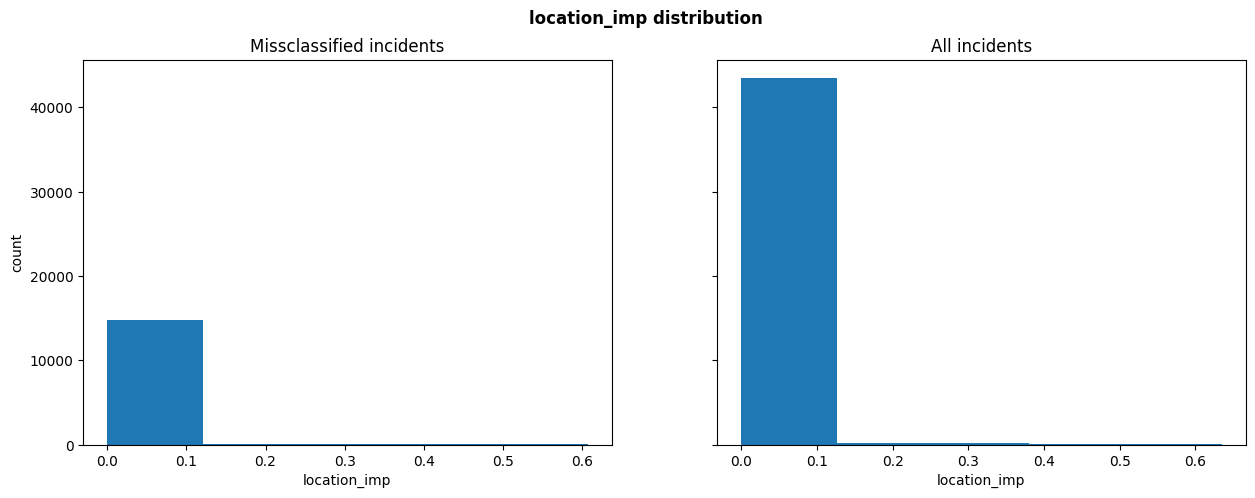

In [42]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_smote_test,
    incidents_test_df,
    'location_imp',
    'hist',
    bins=5,
    title='location_imp distribution'
)

We can notice that for **location_imp** we have similar distribuition shapes. For **road**, **aggression**  and **suicide** we have that the percentage of misclassified incidents with the tag set to True is less than the one on the entire dataset, in particular there are very few miscassified incidents with **suicide** tag set to true. About **n_killed** we can say that the two distribution are quite similar, except that the percentage of miscassified incidents with n_killed = 0 is very low compared to the one on the entire dataset.

## Final considerations

KNN is a good algorithm for classification since it's easy and quite fast to execute. In our case, we found the best hyperparameter but we still didn't reach a satisfactory result. So, we think that other more colpex classifiers will have better performance on our dataset.